## Annotation enrichemts
annotations done with VEP, checking to see if any annotaiton classes are enriched for pcqlts vs eqtls

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [3]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_high_corr_skip.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

# load data

In [4]:
# load in the data from all tissues
vep_dfs = [load_vep(config, tissue_id) for tissue_id in tissue_ids]
vep_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(vep_dfs, tissue_ids)])
vep_df['chr'] = 'chr' + vep_df['#CHROM'].astype(str)
vep_df.reset_index(inplace=True, drop=True)
vep_df

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,cs_full_id,variant_list,...,pc_overlap_all,num_e_overlap_all,num_pc_overlap_all,var_cluster,pc_num,cluster_size,lead_variant_pos,pc_order,tissue_id,chr
0,1,103535612,chr1_103535612_G_A_b38,G,A,.,.,CSQ=A|intron_variant|MODIFIER|RNPC3|ENSG000001...,ENSG00000185946.15_ENSG00000240038.6_e_ENSG000...,"['chr1_103501179_C_G_b38', 'chr1_103506059_T_C...",...,[],1,0,chr1_103535612_G_A_b38_ENSG00000185946.15_ENSG...,0,2,103535612,eqtl,Adipose_Subcutaneous,chr1
1,1,103555063,chr1_103555063_C_T_b38,C,T,.,.,CSQ=T|5_prime_UTR_variant|MODIFIER|AMY2B|ENSG0...,ENSG00000185946.15_ENSG00000240038.6_pc1_cs2,"['chr1_103540130_G_C_b38', 'chr1_103555063_C_T...",...,['ENSG00000185946.15_ENSG00000240038.6_pc1_cs2'],0,1,chr1_103555063_C_T_b38_ENSG00000185946.15_ENSG...,1,2,103555063,first,Adipose_Subcutaneous,chr1
2,1,103566260,chr1_103566260_A_G_b38,A,G,.,.,CSQ=G|intron_variant|MODIFIER|AMY2B|ENSG000002...,ENSG00000185946.15_ENSG00000240038.6_e_ENSG000...,['chr1_103566260_A_G_b38'],...,['ENSG00000185946.15_ENSG00000240038.6_pc1_cs1'],2,1,chr1_103566260_A_G_b38_ENSG00000185946.15_ENSG...,0,2,103566260,eqtl,Adipose_Subcutaneous,chr1
3,1,103566260,chr1_103566260_A_G_b38,A,G,.,.,CSQ=G|intron_variant|MODIFIER|AMY2B|ENSG000002...,ENSG00000185946.15_ENSG00000240038.6_e_ENSG000...,['chr1_103566260_A_G_b38'],...,['ENSG00000185946.15_ENSG00000240038.6_pc1_cs1'],2,1,chr1_103566260_A_G_b38_ENSG00000185946.15_ENSG...,0,2,103566260,eqtl,Adipose_Subcutaneous,chr1
4,1,103566260,chr1_103566260_A_G_b38,A,G,.,.,CSQ=G|intron_variant|MODIFIER|AMY2B|ENSG000002...,ENSG00000185946.15_ENSG00000240038.6_pc1_cs1,['chr1_103566260_A_G_b38'],...,['ENSG00000185946.15_ENSG00000240038.6_pc1_cs1'],2,1,chr1_103566260_A_G_b38_ENSG00000185946.15_ENSG...,1,2,103566260,first,Adipose_Subcutaneous,chr1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8125,9,137073450,chr9_137073450_GCTCTGACCACTTC_G_b38,GCTCTGACCACTTC,G,.,.,CSQ=-|upstream_gene_variant|MODIFIER|UAP1L1|EN...,ENSG00000177239.14_ENSG00000186193.8_ENSG00000...,['chr9_137073450_GCTCTGACCACTTC_G_b38'],...,['ENSG00000177239.14_ENSG00000186193.8_ENSG000...,3,1,chr9_137073450_GCTCTGACCACTTC_G_b38_ENSG000001...,1,3,137073450,first,Whole_Blood,chr9
8126,9,137078448,chr9_137078448_T_C_b38,T,C,.,.,CSQ=C|synonymous_variant|LOW|UAP1L1|ENSG000001...,ENSG00000177239.14_ENSG00000186193.8_ENSG00000...,"['chr9_137073450_GCTCTGACCACTTC_G_b38', 'chr9_...",...,['ENSG00000177239.14_ENSG00000186193.8_ENSG000...,3,1,chr9_137078448_T_C_b38_ENSG00000177239.14_ENSG...,0,3,137078448,eqtl,Whole_Blood,chr9
8127,9,137099650,chr9_137099650_G_A_b38,G,A,.,.,CSQ=A|intron_variant&NMD_transcript_variant|MO...,ENSG00000177239.14_ENSG00000186193.8_ENSG00000...,"['chr9_137099650_G_A_b38', 'chr9_137109777_C_G...",...,[],1,0,chr9_137099650_G_A_b38_ENSG00000177239.14_ENSG...,0,3,137099650,eqtl,Whole_Blood,chr9
8128,9,137108975,chr9_137108975_A_G_b38,A,G,.,.,CSQ=G|downstream_gene_variant|MODIFIER|DPP7|EN...,ENSG00000177239.14_ENSG00000186193.8_ENSG00000...,"['chr9_137069483_A_G_b38', 'chr9_137074738_T_C...",...,['ENSG00000177239.14_ENSG00000186193.8_ENSG000...,0,1,chr9_137108975_A_G_b38_ENSG00000177239.14_ENSG...,2,3,137108975,middle,Whole_Blood,chr9


In [5]:
# load in the gene information 
gid_gencode, full_gencode = load_gencode()

<AxesSubplot: xlabel='pc_order', ylabel='Percent'>

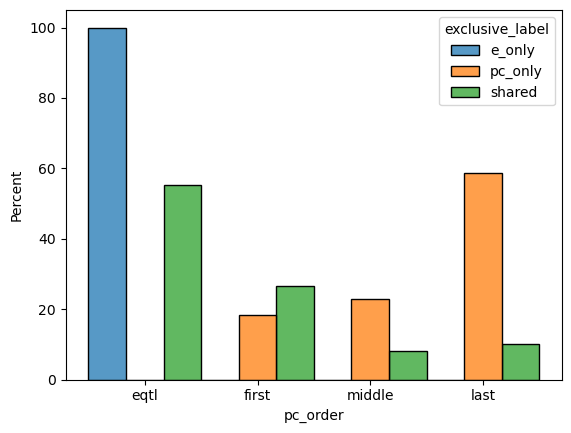

In [29]:
vep_df['exclusive_label'] = 'shared'
vep_df.loc[((vep_df['num_pc_overlap']>0) & (vep_df['num_e_overlap']==0)), 'exclusive_label'] = 'pc_only'
vep_df.loc[((vep_df['num_pc_overlap']==0) & (vep_df['num_e_overlap']>0)), 'exclusive_label'] = 'e_only'

sns.histplot(vep_df, hue='exclusive_label', x='pc_order', common_norm=False, multiple='dodge', stat='percent')

## VEP
vep annotates with variant categories

all the useful information is in the 'INFO' column:



Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS



* One info tags for each transcript the variant impacts, these are seperated by commas
* if an allele has multiple impacts on the same transcript, those appear to be listed with an &

In [6]:
# as an example
vep_df.iloc[4].INFO

'CSQ=G|intron_variant|MODIFIER|AMY2B|ENSG00000240038|Transcript|ENST00000361355|protein_coding||2/11||||||||rs77729677||1||HGNC|HGNC:478|ENST00000453959|0.0312|||1||||||,G|upstream_gene_variant|MODIFIER|ACTG1P4|ENSG00000236085|Transcript|ENST00000425123|processed_pseudogene||||||||||rs77729677|3293|1||HGNC|HGNC:149|ENST00000453959|0.0312|||1||||||,G|intron_variant|MODIFIER|AMY2B|ENSG00000240038|Transcript|ENST00000435302|protein_coding||2/3||||||||rs77729677||1|cds_end_NF|HGNC|HGNC:478|ENST00000453959|0.0312|||1||||||,G|intron_variant|MODIFIER|AMY2B|ENSG00000240038|Transcript|ENST00000453959|protein_coding||1/2||||||||rs77729677||1|cds_end_NF|HGNC|HGNC:478|ENST00000453959|0.0312|||1||||||,G|intron_variant&NMD_transcript_variant|MODIFIER|AMY2B|ENSG00000240038|Transcript|ENST00000477657|nonsense_mediated_decay||1/9||||||||rs77729677||1||HGNC|HGNC:478|ENST00000453959|0.0312|||1||||||,G|upstream_gene_variant|MODIFIER|AMY2B|ENSG00000240038|Transcript|ENST00000491397|protein_coding_CDS_not_d

In [7]:
# a version with lists of the info fields, still only one row per cs
# I think this is better because, ie a variant would be listed as coding for each transcript its in, but I don't want to count each of those

def get_info_list(row, idx):
    return list(set([item.split('|')[idx] for item in row.INFO.split(',')]))

info_tags = 'Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS'
info_tags = info_tags.split('|')

for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    vep_df[tag_name] = vep_df.apply(get_info_list, args=(i,), axis=1)

Allele
Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


In [8]:
# make a list of the tissues for each ID
tissue_list = vep_df.groupby('ID')['tissue_id'].apply(list)
vep_df['tissue_list'] = vep_df['ID'].map(tissue_list)

In [9]:
# vep df should not be deduplicated I think
# just be sure to keep the orig dataset in mind 
#vep_df = vep_df.drop_duplicates('ID')

#### Consequence

In [10]:
# some conseqeunces have an '&' in their name if multiple consequnces are prediced for the variant on the same transcript. 
# I will split those

def split_consequence(row):
    return list(set([indv_c for c in row['Consequence'] for indv_c in c.split('&')]))

vep_df['consequence_set'] = vep_df.apply(split_consequence, axis=1)

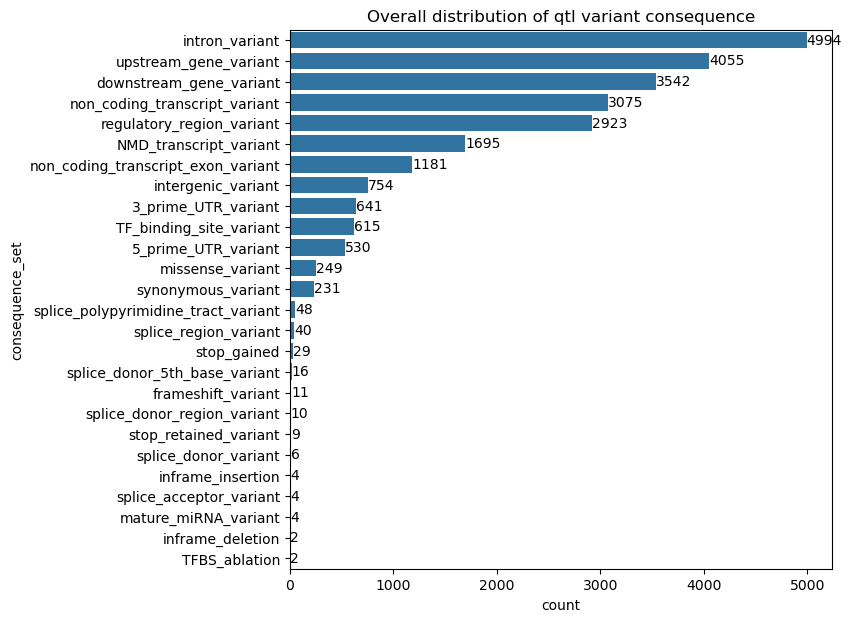

In [11]:
fig, ax = plt.subplots(figsize=(7,7))
ordered_c_categories = vep_df.explode('consequence_set')['consequence_set'].value_counts().index
y = sns.countplot(vep_df.explode('consequence_set'), y='consequence_set', ax=ax, order=ordered_c_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant consequence')
plt.show()

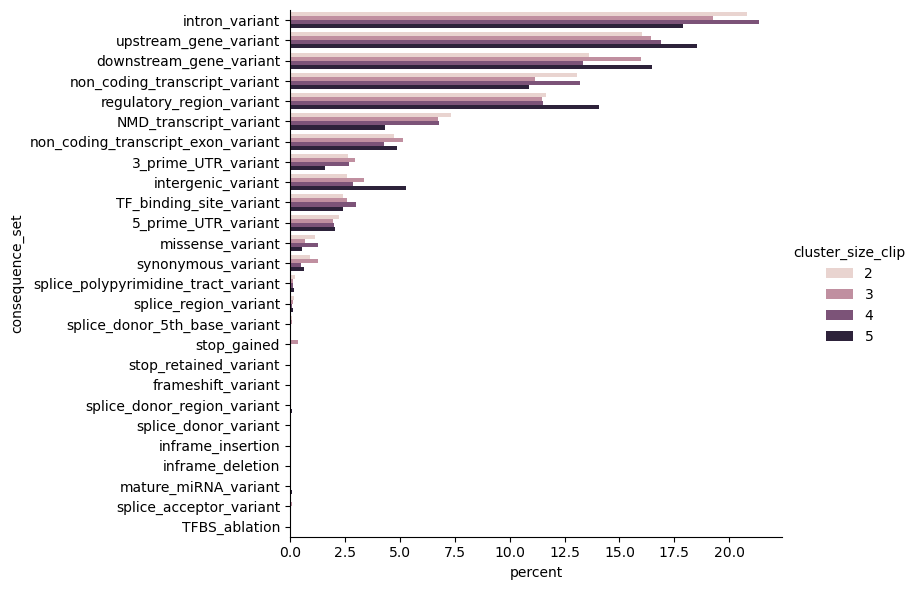

In [12]:
vep_df['cluster_size_clip'] = vep_df['cluster_size'].clip(0,5)
data_to_plot = vep_df.explode('consequence_set').groupby('cluster_size_clip')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='cluster_size_clip',kind='bar',height=6, aspect=1.4)


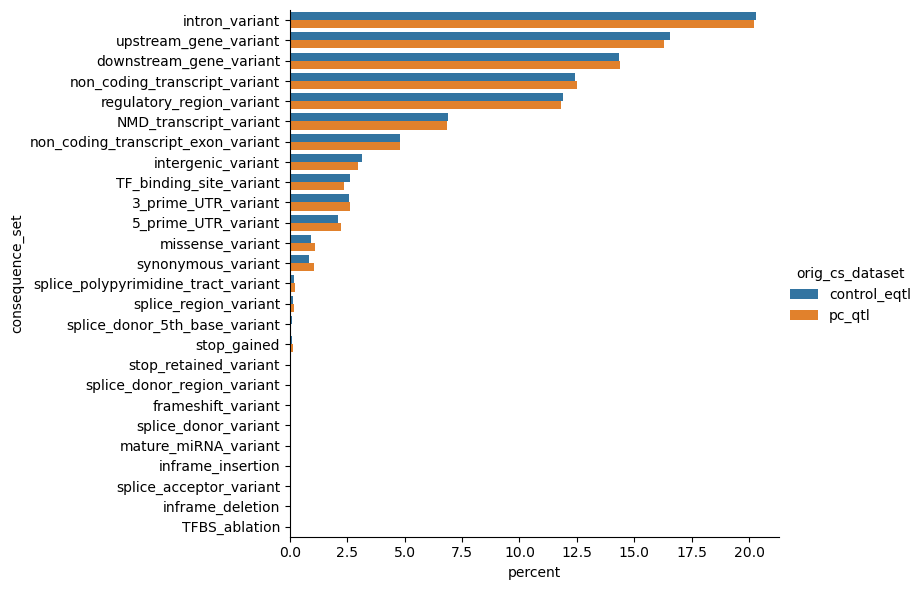

In [13]:
data_to_plot = vep_df.explode('consequence_set').groupby('orig_cs_dataset')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='orig_cs_dataset',kind='bar', height=6, aspect=1.4)

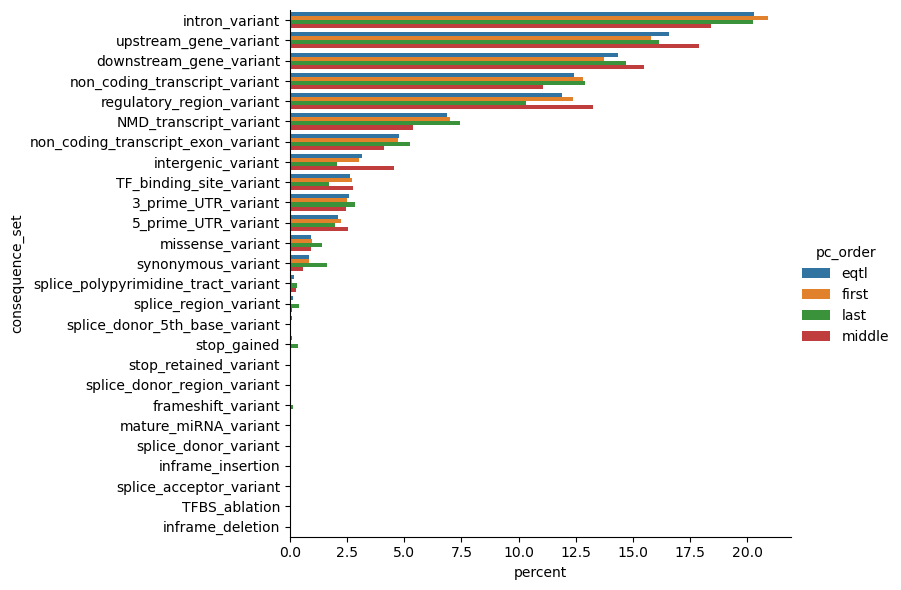

In [14]:
data_to_plot = vep_df.explode('consequence_set').groupby('pc_order')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


##### log odds

In [15]:
# error bars on log odds come from error propegation for counts
def calculate_log_odds_error(counts1_positive, counts1_total, counts2_positive, counts2_total):
    counts1_negative = counts1_total-counts1_positive
    counts2_negative = counts2_total-counts2_positive

    # calculate the odds ratio
    or_ratio = (counts1_positive / counts1_negative) / (counts2_positive / counts2_negative)

    # calculate the standard error
    SE_log_OR = np.sqrt(1/counts1_positive - 1/counts1_negative + 1/counts2_positive - 1/counts2_negative)
    lower_bound, upper_bound = np.exp(np.log(or_ratio) - 1.96*SE_log_OR), np.exp(np.log(or_ratio) + 1.96*SE_log_OR)

    return np.log2(or_ratio), np.log2(lower_bound), np.log2(upper_bound)


def get_or_counts(vep_df, key_col='consequence_set'):
    return vep_df.explode(key_col).value_counts(key_col)

def get_odds_df(counts1, name1, counts2, name2, ordered_categories):
    or_df = pd.DataFrame({name1: counts1, name2: counts2})

    # add the odds ratios and 95% cis
    for idx in or_df.index:
        or_ratio, lower_bound, upper_bound = calculate_log_odds_error(or_df.loc[idx][name1], or_df[name1].sum(), or_df.loc[idx][name2], or_df[name2].sum())
        or_df.loc[idx, 'or_ratio'] = or_ratio
        or_df.loc[idx, 'lower_bound'] = lower_bound
        or_df.loc[idx, 'upper_bound'] = upper_bound

    or_df['upper_err_abs'] = or_df['upper_bound'] - or_df['or_ratio']
    or_df['lower_err_abs'] = or_df['or_ratio'] - or_df['lower_bound']
    return or_df.loc[ordered_categories[ordered_categories.isin(or_df.index)]].reset_index()

def plot_log_odds(or_df, title, key_col='consequence_set', ax=None, offset=-.2):
    if ax==None:
        fig, ax = plt.subplots(figsize=(7,7))
    # reset index to get consequence_set as a column

    ax.errorbar(y=or_df[key_col], x=or_df['or_ratio'], xerr=np.clip(or_df[['lower_err_abs', 'upper_err_abs']].values.transpose(), -3, 3), fmt="o")

    ax.invert_yaxis()
    plt.axvline(0, color='k')
    plt.text(.1, len(or_df)+offset, f'-> {or_df.columns[1]}')
    plt.text(-.1, len(or_df)+offset, f'{or_df.columns[2]} <-', horizontalalignment='right')
    plt.title(title)
    return ax

<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant consequences'}>

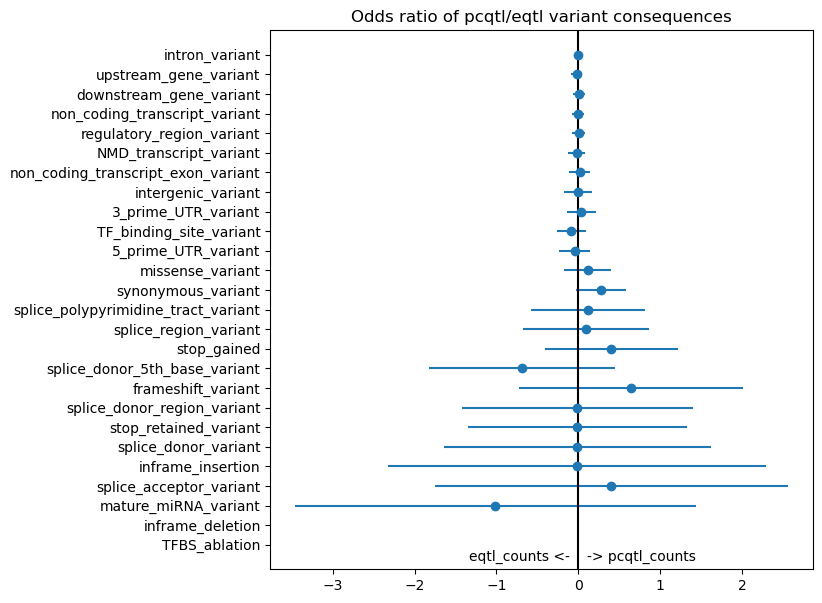

In [16]:
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']>0)])
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of exclusive pcqtl/exclusive eqtl variant consequences'}>

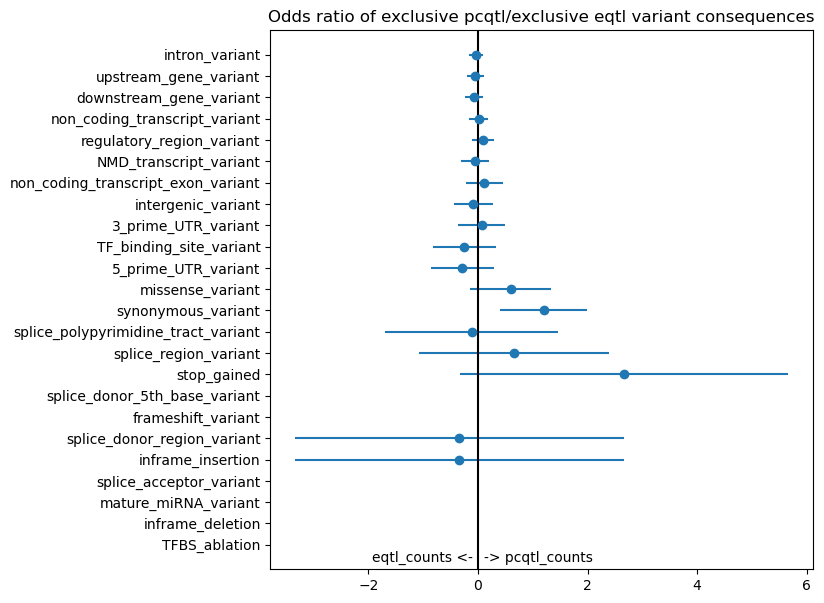

In [30]:
# get counts for all exclusive pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['exclusive_label']=='pc_only')])
eqtl_counts = get_or_counts(vep_df[(vep_df['exclusive_label']=="e_only")])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of exclusive pcqtl/exclusive eqtl variant consequences')

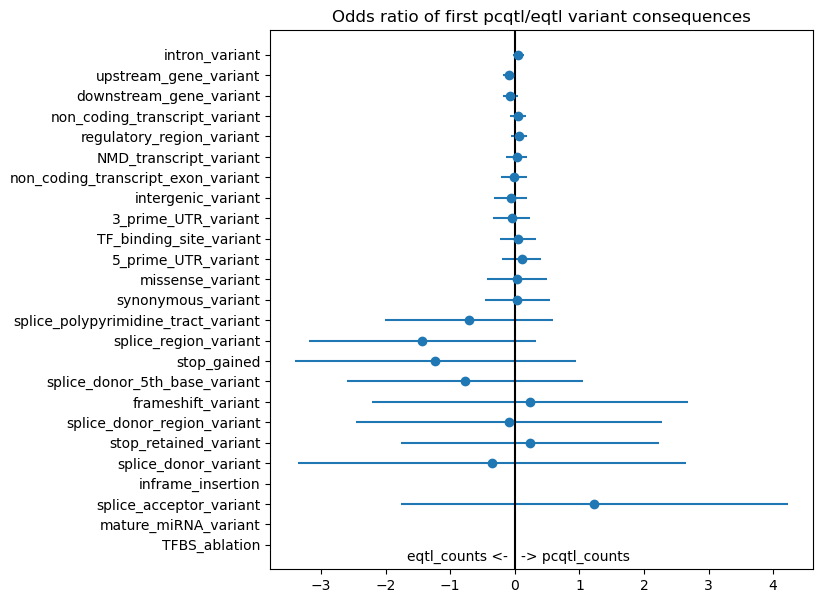

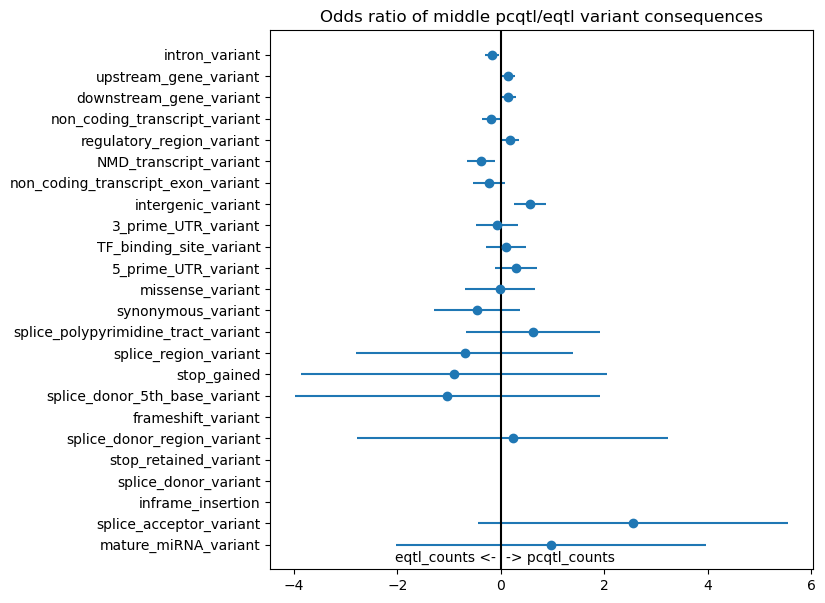

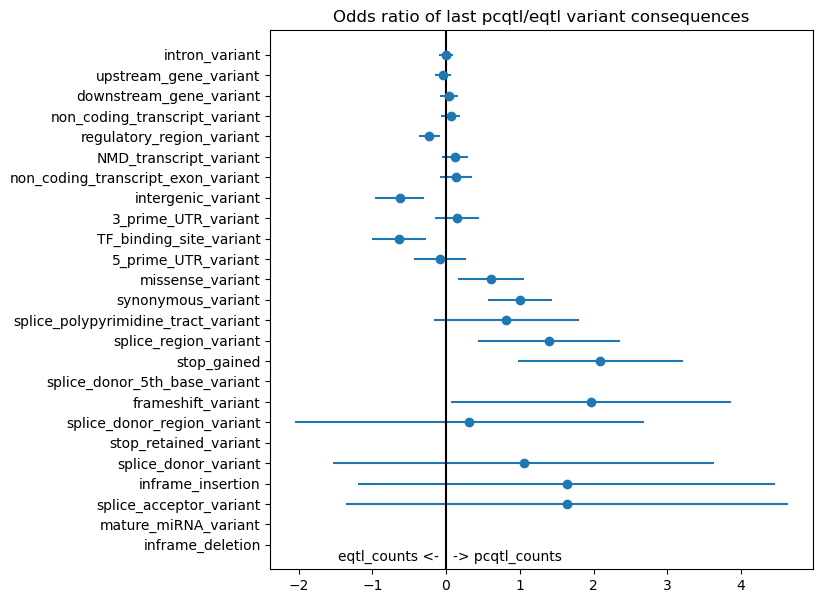

In [17]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_order']==order)])
    eqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==0)])

    # format into a df and get the error bars
    or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_c_categories)

    # plot
    plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of first, middle pcqtl/last pcqtl variant consequences'}>

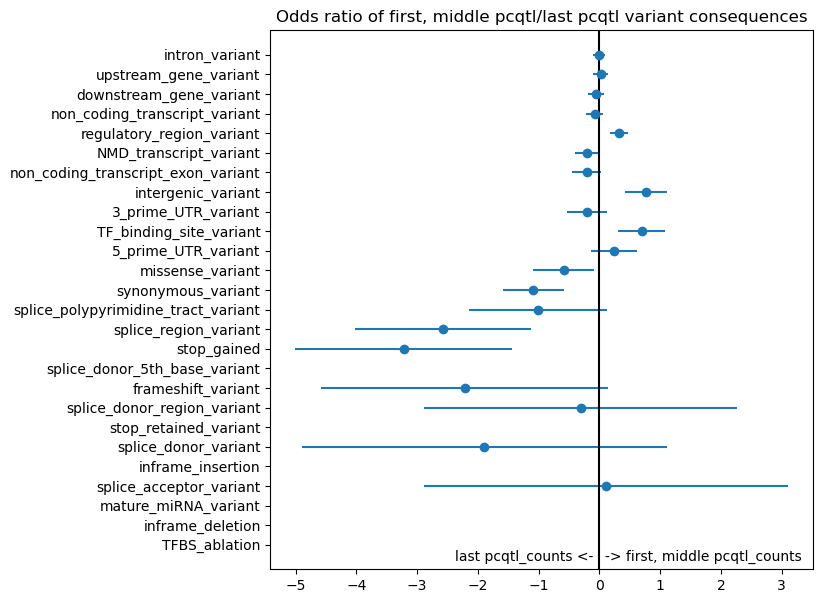

In [21]:
# get counts for all pc1qtl  vs pc2qtl
pc1qtl_counts = get_or_counts(vep_df[(vep_df['pc_order'].isin(['first', 'middle']))])
pc2qtl_counts = get_or_counts(vep_df[(vep_df['pc_order']=='last')])

# format into a df and get the error bars
or_df = get_odds_df(pc1qtl_counts, 'first, middle pcqtl_counts', pc2qtl_counts, 'last pcqtl_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of first, middle pcqtl/last pcqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of single egene vs multi egene eqtl variant consequences'}>

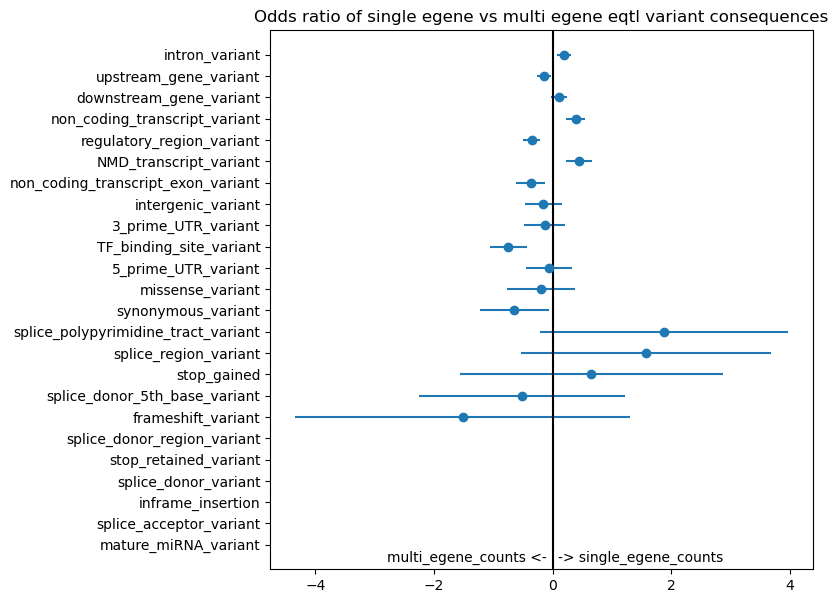

In [22]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']==1)])
multi_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']>1)])

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant consequences')

### Biotype

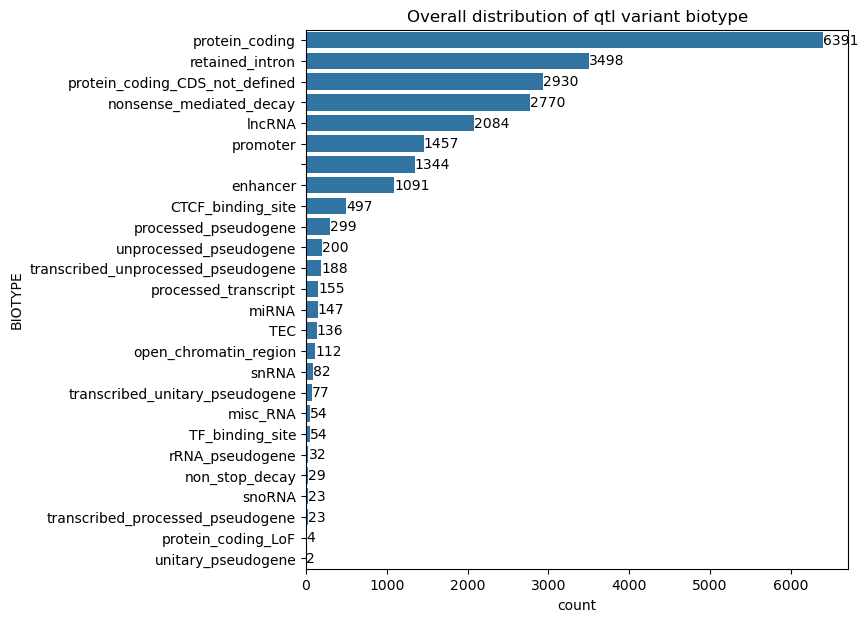

In [31]:
# overall distribution of biotype
fig, ax = plt.subplots(figsize=(7,7))
ordered_b_categories = vep_df.explode('BIOTYPE')['BIOTYPE'].value_counts().index
y = sns.countplot(vep_df.explode('BIOTYPE'), y='BIOTYPE', ax=ax, order=ordered_b_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant biotype')
plt.show()

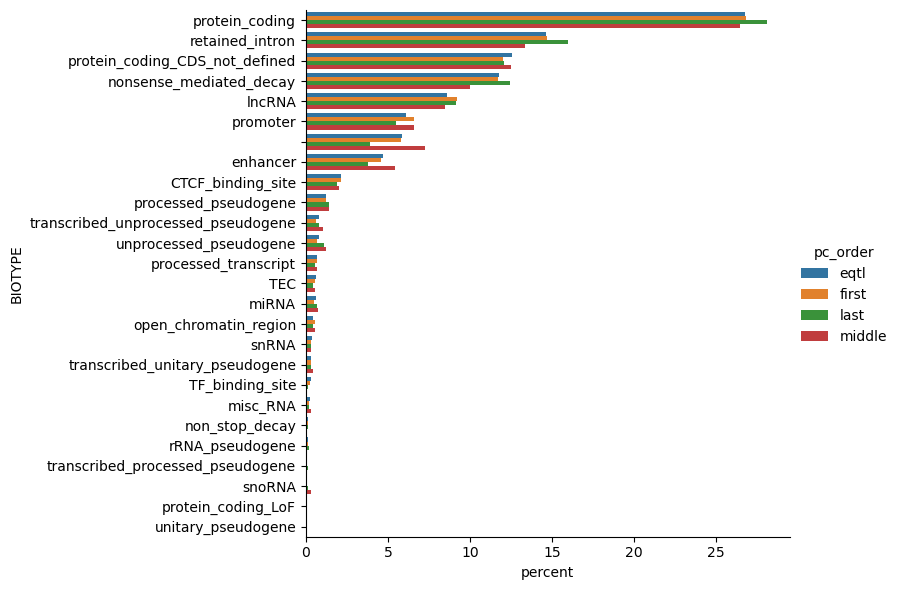

In [32]:
data_to_plot = vep_df.explode('BIOTYPE').groupby('pc_order')['BIOTYPE'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='BIOTYPE',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant biotype'}>

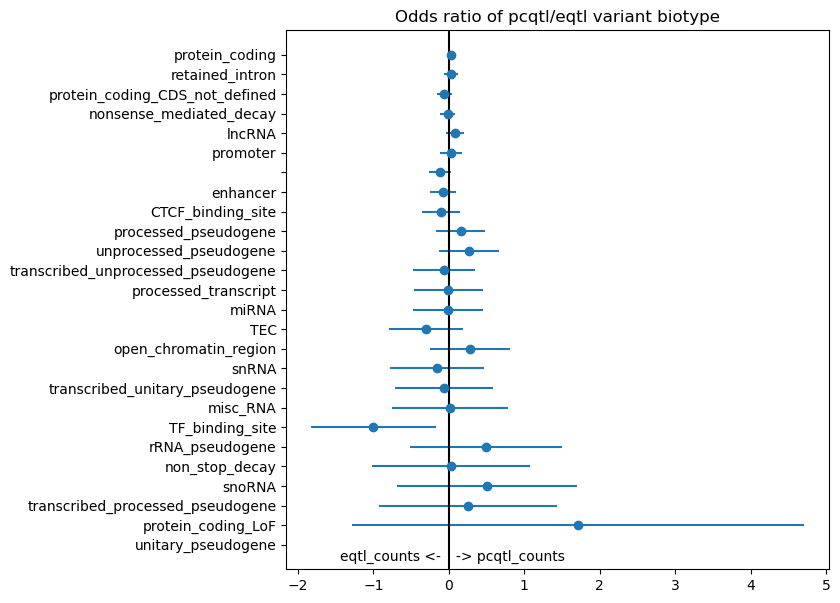

In [33]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']>0)], key_col='BIOTYPE')
eqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==0)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant biotype', key_col='BIOTYPE')

<AxesSubplot: title={'center': 'Odds ratio of single egene vs multi egene eqtl variant biotype'}>

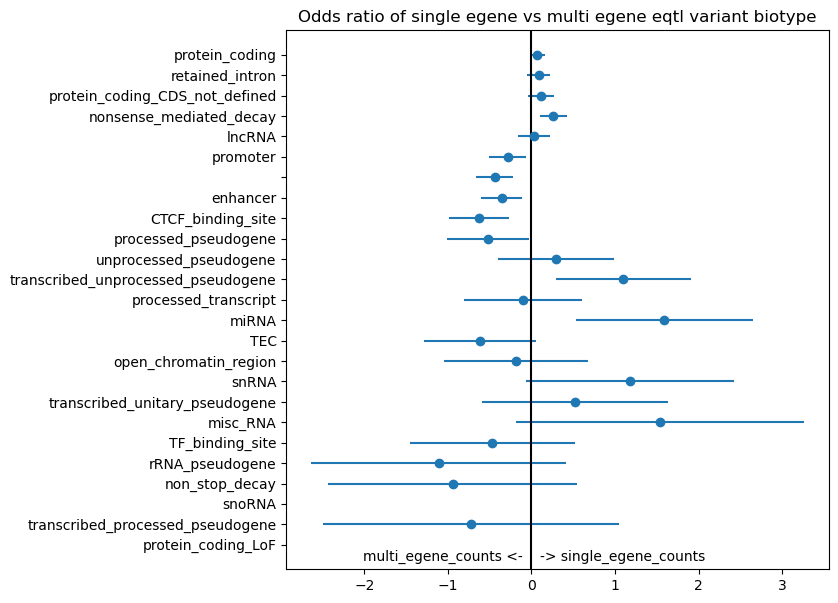

In [34]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']==1)], key_col='BIOTYPE')
multi_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']>1)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant biotype', key_col='BIOTYPE')

### Transcription factors

In [35]:
# TFs are split with :: and &
def split_tfs(row):
    split_tfs = [indv_tf for tf in row['TRANSCRIPTION_FACTORS'] for indv_tf in tf.split('&')]
    split_tfs = [indv_tf for tf in split_tfs for indv_tf in tf.split('::')]
    return list(set(split_tfs))

vep_df['tf_set'] = vep_df.apply(split_tfs, axis=1)

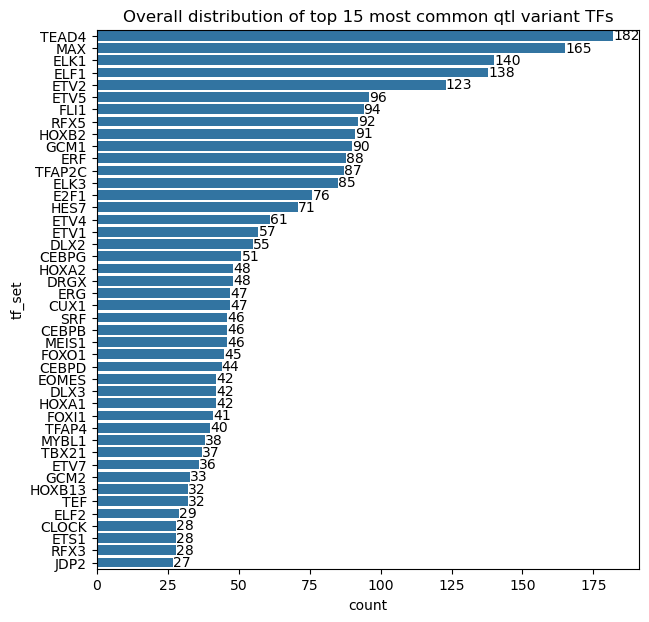

In [36]:
# overall distribution of transcription factors
fig, ax = plt.subplots(figsize=(7,7))
ordered_t_categories = vep_df.explode('tf_set')['tf_set'].value_counts().index
subsample_df = vep_df.explode('tf_set')
subsample_df = subsample_df[subsample_df['tf_set'].isin(ordered_t_categories[1:45])]
y = sns.countplot(subsample_df, y='tf_set', ax=ax, order=ordered_t_categories[1:45])
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of top 15 most common qtl variant TFs')
plt.show()

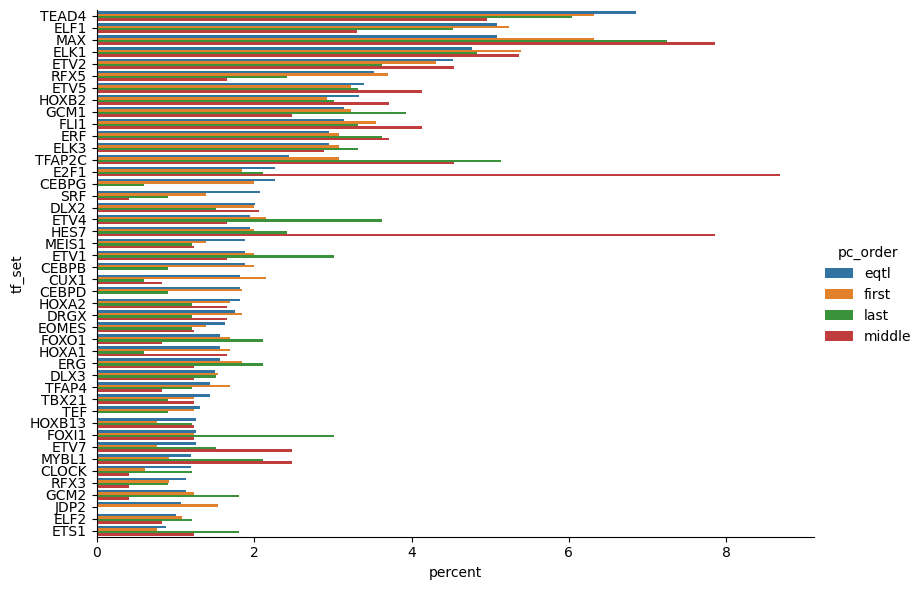

In [37]:
data_to_plot = subsample_df.explode('tf_set').groupby('pc_order')['tf_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='tf_set',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant tf'}>

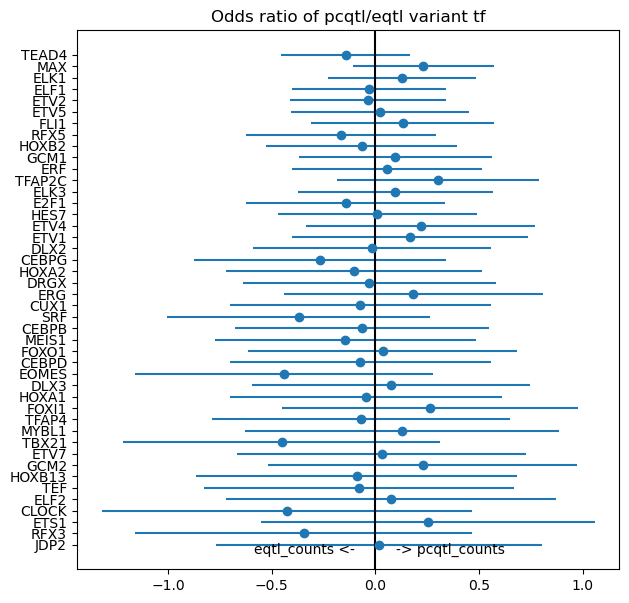

In [38]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(subsample_df[(subsample_df['num_pc_samelead']>0)], key_col='tf_set')
eqtl_counts = get_or_counts(subsample_df[(subsample_df['num_e_samelead']>0)], key_col='tf_set')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_t_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant tf', key_col='tf_set')

## for presnetaitons

highlight a few interesting columns


**consequence**

NMD 

regulatory

TF binding

**biotype**

CTCF

enhancer

promotor

In [48]:
def selected_feature_or_df(df1, name1, df2, name2, features):
    # get biotype df
    df1_counts = get_or_counts(df1, key_col='BIOTYPE')
    df2_counts = get_or_counts(df2, key_col='BIOTYPE')

    # format into a df and get the error bars
    bio_or_df = get_odds_df(df1_counts, name1, df2_counts, name2 , ordered_categories=ordered_b_categories)

    # gert conseqeucne df
    df1_counts = get_or_counts(df1)
    df2_counts = get_or_counts(df2)

    # format into a df and get the error bars
    cons_or_df = get_odds_df(df1_counts, name1, df2_counts, name2, ordered_c_categories)

    # make into one df
    bio_or_df=bio_or_df.rename(columns={'BIOTYPE':'feature'})
    cons_or_df = cons_or_df.rename(columns={'consequence_set':'feature'})

    or_df = pd.concat([bio_or_df, cons_or_df])
    return or_df.set_index('feature').loc[features].reset_index()

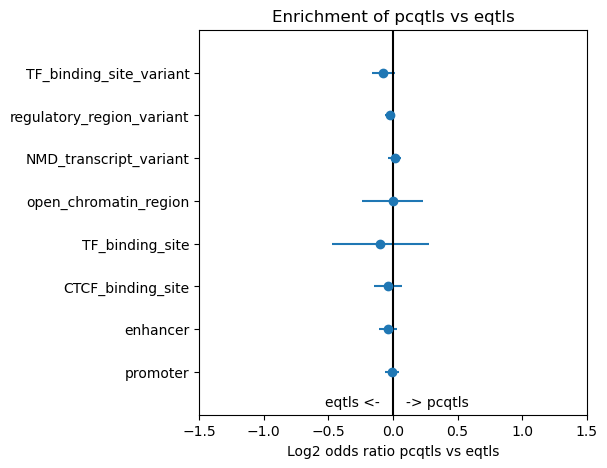

In [54]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[vep_df['pc_num']>0], 'pcqtls', vep_df[vep_df['pc_num']==0], 'eqtls', features)



fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio pcqtls vs eqtls')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


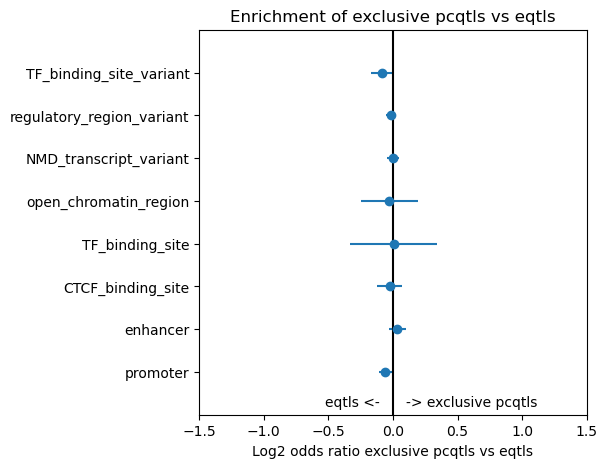

In [56]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[(vep_df['pc_num']>0)& vep_df['num_e_overlap']==0], 'exclusive pcqtls', vep_df[vep_df['pc_num']==0], 'eqtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of exclusive pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio exclusive pcqtls vs eqtls')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


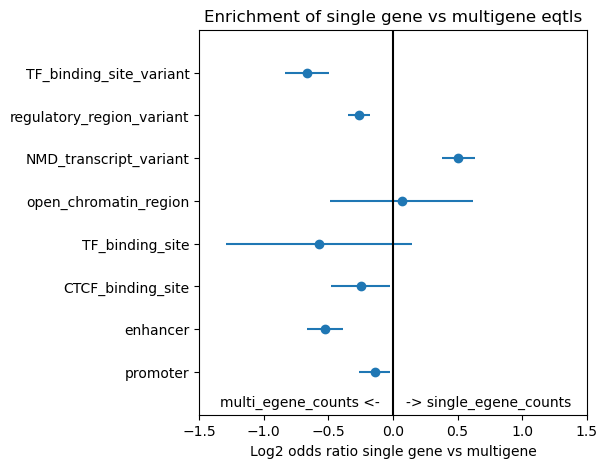

In [57]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']

or_df = selected_feature_or_df(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']==1)], 'single_egene_counts', vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']>1)], 'multi_egene_counts', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of single gene vs multigene eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


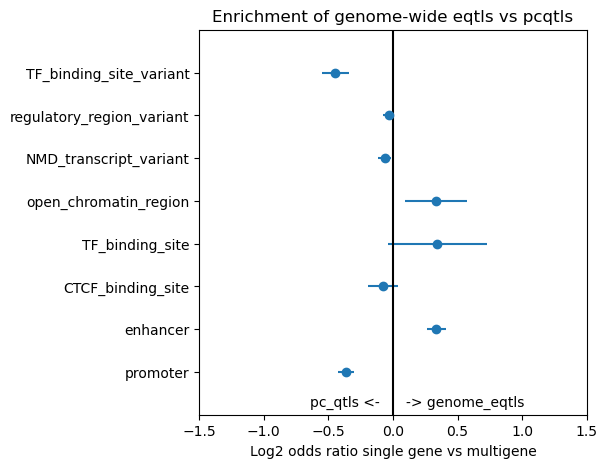

In [58]:
# get counts genome-wide eqtls vs pcqtls

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
# get counts for all eqtls vs pcqtls

or_df = selected_feature_or_df(control_vep_df, 'genome_eqtls', vep_df[vep_df['pc_num']>0], 'pc_qtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of genome-wide eqtls vs pcqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


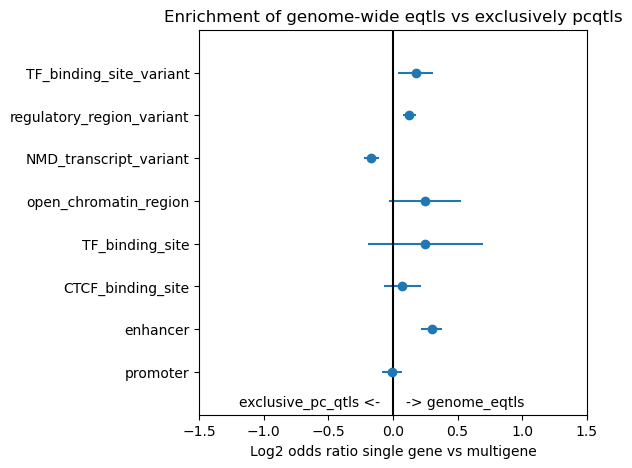

In [59]:
# get counts genome-wide eqtls vs exclusive pcqtls

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
# get counts for all eqtls vs pcqtls

or_df = selected_feature_or_df(control_vep_df, 'genome_eqtls', vep_df[(vep_df['num_pc_samelead']>0) & (vep_df['num_e_samelead']==0)], 'exclusive_pc_qtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of genome-wide eqtls vs exclusively pcqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


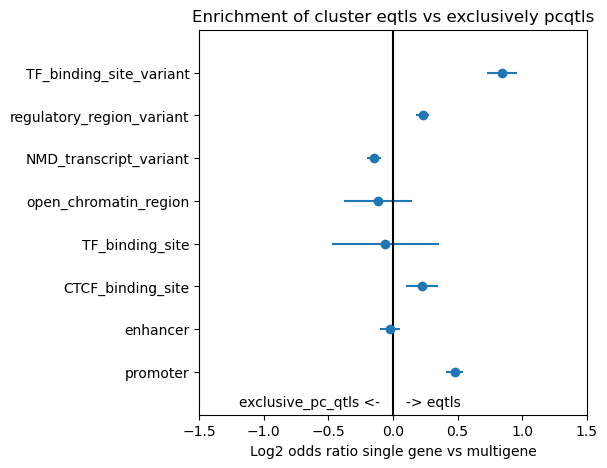

In [60]:
# get counts genome-wide eqtls vs exclusive pcqtls

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
# get counts for all eqtls vs pcqtls

or_df = selected_feature_or_df(vep_df[(vep_df['num_e_samelead']>0)], 'eqtls', vep_df[(vep_df['num_pc_samelead']>0) & (vep_df['num_e_samelead']==0)], 'exclusive_pc_qtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of cluster eqtls vs exclusively pcqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


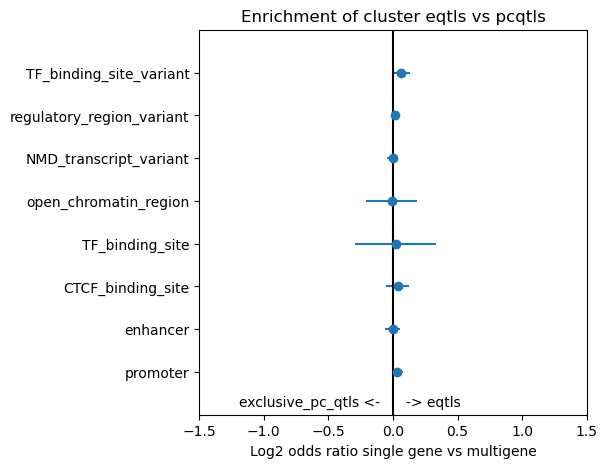

In [61]:
# get counts genome-wide eqtls vs exclusive pcqtls

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
# get counts for all eqtls vs pcqtls

or_df = selected_feature_or_df(vep_df[(vep_df['num_e_samelead']>0)], 'eqtls', vep_df[(vep_df['num_pc_samelead']>0)], 'exclusive_pc_qtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of cluster eqtls vs pcqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()
